In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir("/content/drive/MyDrive/AI/dataset/pneumonia/chest_xray")

In [ ]:
pwd

'/content/drive/MyDrive/AI/dataset/pneumonia/chest_xray'

In [ ]:
!ls

model_PNEUMONIA.h5  output  test  train  val


In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

print(tf.__version__)

warnings.filterwarnings("ignore")
SEED = 42   # set random seed


2.8.0


In [ ]:
a=list(paths.list_images("train")) #define data path

In [ ]:
a[22]

'train/NORMAL/IM-0545-0001-0002.jpeg'

In [ ]:
# create CNN Model

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

      
        model.add(Dense(100))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(2))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("train")))

random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]


        if label == "NORMAL":
            label = 0
        elif label == "PNEUMONIA":
            label = 1
        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/5216 [00:00<?, ?it/s]

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
print(len(data))
print(len(labels))


5216
5216


In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [ ]:
print("Train x SHAPE: ", trainX.shape)
print("Test x SHAPE: ", testX.shape)

Train x SHAPE:  (3912, 28, 28, 3)
Test x SHAPE:  (1304, 28, 28, 3)


In [ ]:
print(len(testY), len(trainY))

1304 3912


In [ ]:
testY

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [ ]:
testY[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=2)
opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        1520      
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                    

In [ ]:
EPOCHS = 30
BS = 11
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Epoch 1/30
355/355 [==============================] - 15s 14ms/step - loss: 0.5557 - accuracy: 0.7465 - val_loss: 0.4796 - val_accuracy: 0.7431
Epoch 2/30
355/355 [==============================] - 5s 13ms/step - loss: 0.3897 - accuracy: 0.8208 - val_loss: 0.3795 - val_accuracy: 0.8183
Epoch 3/30
355/355 [==============================] - 5s 13ms/step - loss: 0.3245 - accuracy: 0.8621 - val_loss: 0.2892 - val_accuracy: 0.8727
Epoch 4/30
355/355 [==============================] - 5s 13ms/step - loss: 0.3004 - accuracy: 0.8736 - val_loss: 0.2771 - val_accuracy: 0.8811
Epoch 5/30
355/355 [==============================] - 4s 12ms/step - loss: 0.2650 - accuracy: 0.8775 - val_loss: 0.1768 - val_accuracy: 0.9379
Epoch 6/30
355/355 [==============================] - 4s 12ms/step - loss: 0.2565 - accuracy: 0.8962 - val_loss: 0.2812 - val_accuracy: 0.8804
Epoch 7/30
355/355 [==============================] - 5s 13ms/step - loss: 0.2578 - accuracy: 0.8870 - val_loss: 0

In [ ]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save('model_PNEUMONIA.h5')

[INFO] serializing network and label binarizer...


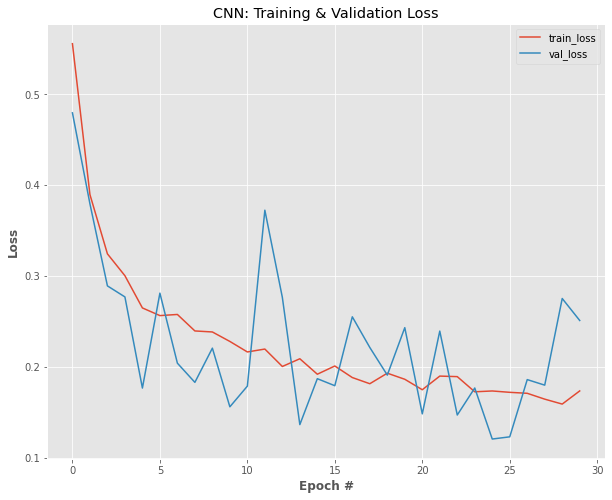

In [ ]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

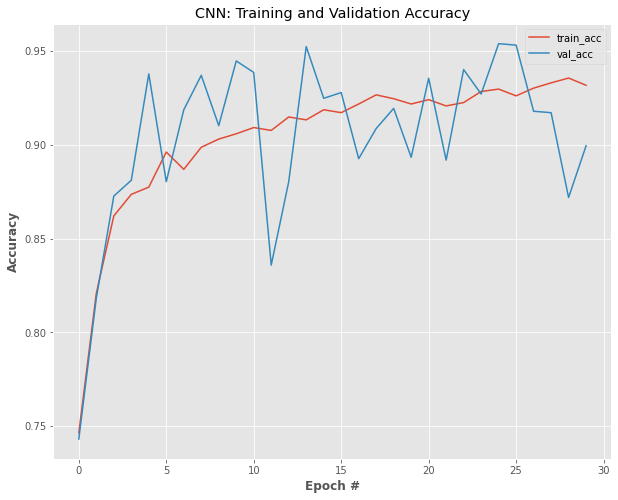

In [ ]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

2.0.0
